In [1]:
'''Fitting an SIRH model to a real dataset. We attempt to learn 
a time dependent parameter beta_t. '''

'Fitting an SIRH model to a real dataset. We attempt to learn \na time dependent parameter beta_t. '

In [2]:
import numpy as np
from epymorph.kit import *
from epymorph.adrio import cdc

import numpy as np
import matplotlib.pyplot as plt
from epymorph.forecasting.likelihood import Poisson
from epymorph.kit import *

from epymorph.simulation import Context
from epymorph.adrio import acs5, us_tiger
from epymorph.forecasting.param_transformations import ExponentialTransform
from epymorph.forecasting.dynamic_params import GaussianPrior, OrnsteinUhlenbeck
from epymorph.adrio.processing import RandomFix

from epymorph.forecasting.pipeline import (
    FromRUME,
    ParticleFilterSimulator,
    Observations,
    ModelLink,
)

from epymorph.attribute import NamePattern

from epymorph.forecasting.pipeline import (
    FromOutput,
    UnknownParam,
)

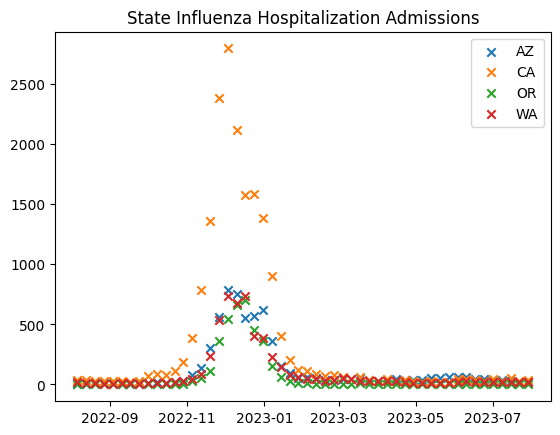

In [10]:
rng = np.random.default_rng(0)
time_frame = TimeFrame.rangex("2022-08-01", "2023-08-01")
scope = StateScope.in_states(["WA","CA","OR","AZ"], year=2019)

cdc_adrio = cdc.InfluenzaStateHospitalization(
).with_context(
    time_frame=time_frame,
    scope= scope
)

real_data_result = cdc_adrio.inspect().result

real_data = real_data_result["value"]
real_data_dates = real_data_result["date"][:, 0]

plt.title('State Influenza Hospitalization Admissions')
for node in range(real_data.shape[1]):
    plt.scatter(real_data_dates,real_data[:,node],label = scope.labels[node],marker = 'x')
plt.legend()
plt.show()


In [4]:
pf_rume = SingleStrataRUME.build(
    # Load the Pei IPM
    ipm=ipm.SIRH(),
    # Load the Pei MM
    mm=mm.Centroids(),
    # Describe the geographic scope of our simulation:
    scope=scope,
    # Create a SingleLocation initializer
    init=init.RandomLocationsAndRandomSeed(scope.nodes,10_000),
    # Set the time-frame to simulate
    time_frame=time_frame,
    # Provide model parameter values
    params={
        "beta": ExponentialTransform("log_beta"),
        "gamma":1/7,
        "xi":1/90,
        "phi":10,
        "hospitalization_duration": 2.5,
        "hospitalization_prob": 200/100_000,
        # Geographic data can be loaded using ADRIOs
        "centroid": us_tiger.InternalPoint(),
        "population": acs5.Population()
    },
)

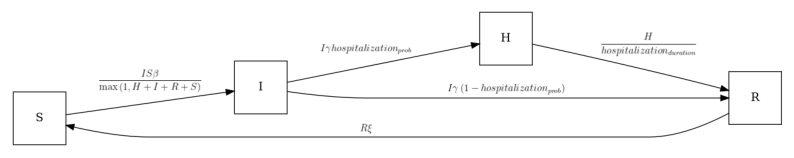

In [5]:
pf_rume.ipm.diagram()

In [6]:
log_beta_damping = 1 / 35
log_beta_mean = np.log(0.2)
log_beta_standard_deviation = 0.50
initial_log_beta = np.log(0.2)

num_realizations = 100

In [7]:
my_observations = Observations(
    source=cdc_adrio,
    model_link=ModelLink(
        geo=pf_rume.scope.select.all(),
        time=pf_rume.time_frame.select.all().agg(),
        quantity=pf_rume.ipm.select.events("I->H"),
    ),
    likelihood=Poisson(),
)

my_unknown_params = {
    "log_beta": UnknownParam(
        prior=GaussianPrior(
            mean=log_beta_mean,
            standard_deviation=log_beta_standard_deviation,
        ),
        dynamics=OrnsteinUhlenbeck(
            damping=log_beta_damping,
            mean=log_beta_mean,
            standard_deviation=log_beta_standard_deviation,
        ),
    )
}

particle_filter_simulator = ParticleFilterSimulator(
        config=FromRUME(pf_rume,num_realizations,unknown_params = my_unknown_params),
        observations=my_observations,
        save_trajectories=True,
    )


In [8]:
particle_filter_output = particle_filter_simulator.run(rng=rng)

AttributeError: 'NoneType' object has no attribute 'map'

In [ ]:
context = Context.of(
    scope=pf_rume.scope,
    # We fetch data starting from the first fitting date to match the first nowcast.
    time_frame=pf_rume.time_frame,
    rng=rng,
)
real_data_result = (
    my_observations.source.with_context_internal(context).inspect().result
)

real_data = real_data_result["value"]

real_data_dates = real_data_result["date"][:, 0]

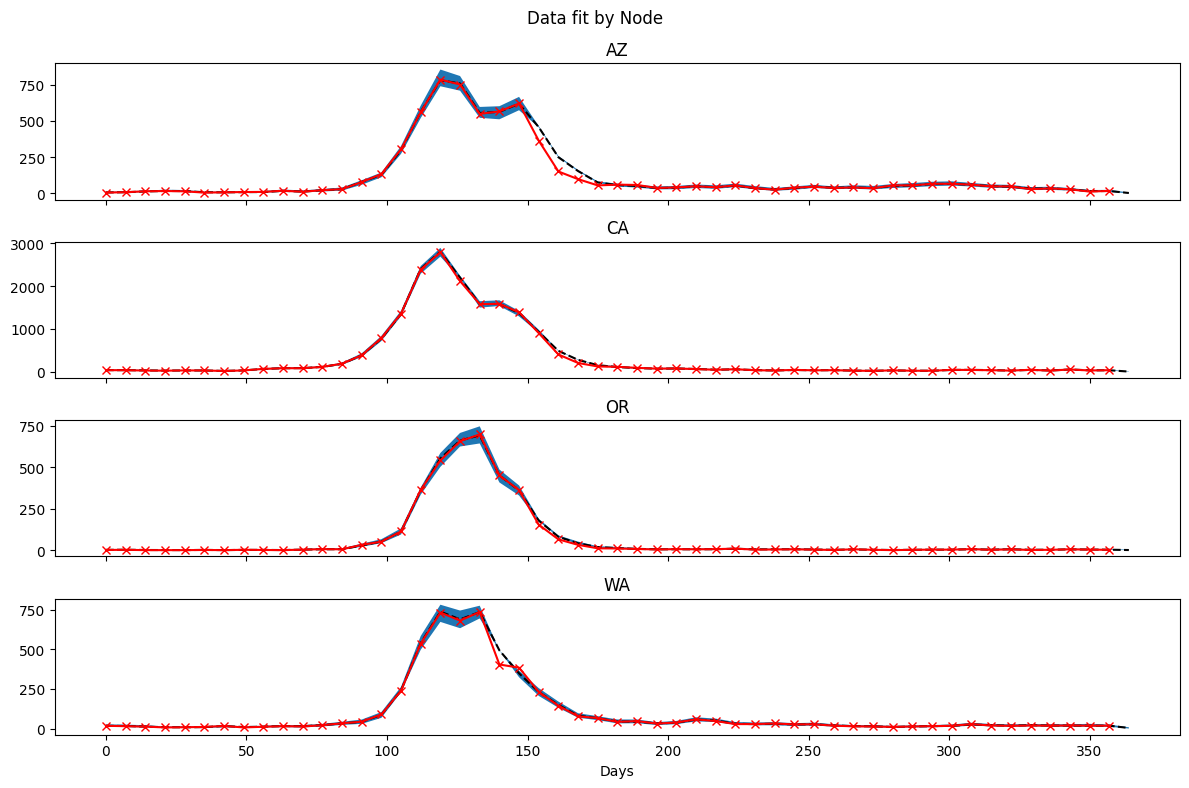

In [ ]:
import matplotlib.pyplot as plt

t_range = np.arange(pf_rume.time_frame.duration_days,step = 7)

fig,ax = plt.subplots(4,figsize = (12,8),sharex=True)

plt.suptitle('Data fit by Node')
for node in range(pf_rume.scope.nodes):
        upper = np.percentile(particle_filter_output.posterior_values[:,:,node,:],97.5,axis = 1)[:,0]
        lower = np.percentile(particle_filter_output.posterior_values[:,:,node,:],2.5,axis = 1)[:,0]
        data_mean = np.mean((particle_filter_output.posterior_values[:,:,node,:]),axis = 1)
        ax[node].set_title(f'{pf_rume.scope.labels[node]}')
        ax[node].plot(t_range,data_mean,'--',label = 'mean',color = 'black')
        ax[node].fill_between(t_range,lower,upper)
        ax[node].plot(t_range[:-1],real_data[:,node],marker = 'x',color = 'red')
ax[-1].set_xlabel('Days')
fig.tight_layout()

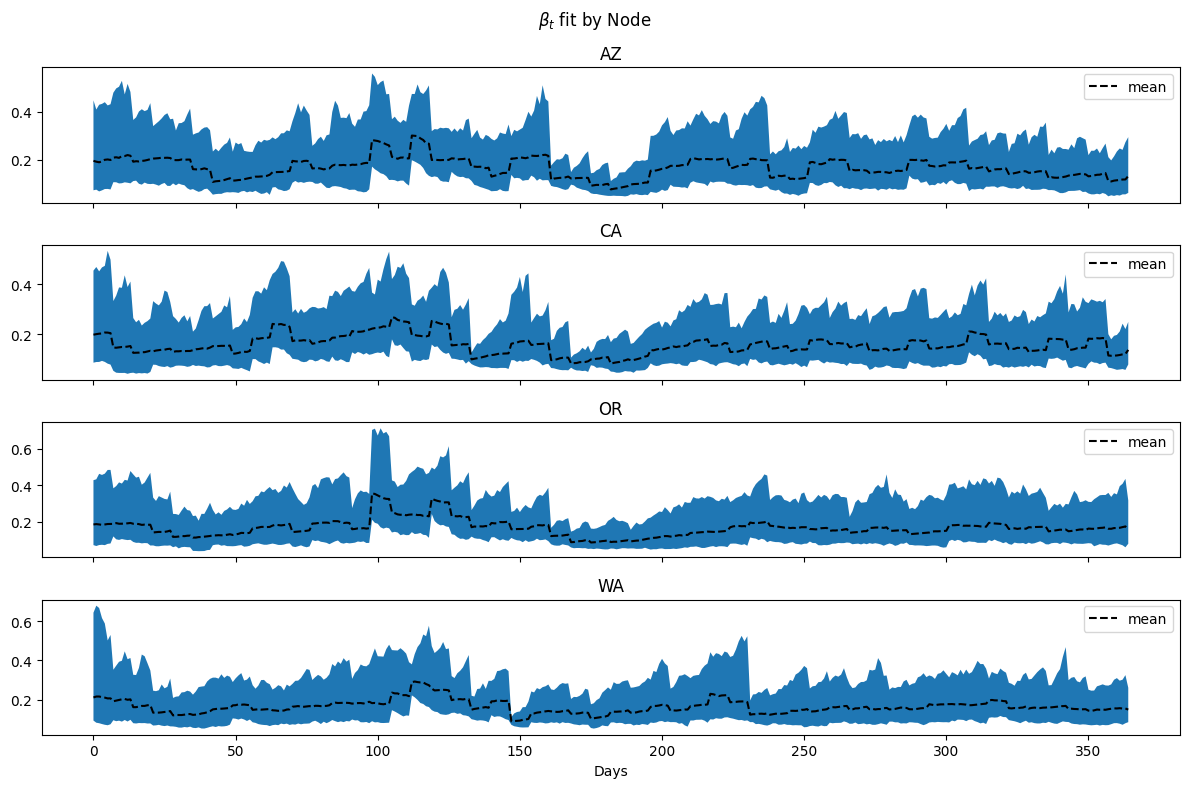

In [ ]:
fig,ax = plt.subplots(4,figsize = (12,8),sharex=True)

t_range = np.arange(pf_rume.time_frame.duration_days)

plt.suptitle('$\\beta_t$ fit by Node')
for node in range(pf_rume.scope.nodes):
        upper = np.percentile(np.exp(particle_filter_output.estimated_params[NamePattern.of("log_beta")][:,:,node]),97.5,axis = 0)
        lower = np.percentile(np.exp(particle_filter_output.estimated_params[NamePattern.of("log_beta")][:,:,node]),2.5,axis = 0)
        beta_mean = np.exp(np.mean(particle_filter_output.estimated_params[NamePattern.of("log_beta")][:,:,node],axis = 0))
        ax[node].set_title(f'{pf_rume.scope.labels[node]}')
        ax[node].fill_between(t_range,lower,upper)
        ax[node].plot(beta_mean,'--',label = 'mean',color = 'black')
        ax[node].legend()
ax[-1].set_xlabel('Days')
fig.tight_layout()


In [ ]:
'''(num_realizations, tau_steps*num_days, num_nodes, num_compartments)'''
pf_states = particle_filter_output.compartments
pf_states = pf_states.reshape(num_realizations,pf_rume.time_frame.duration_days,2,4,4).sum(axis = 2)
print(pf_states.shape)

(100, 365, 4, 4)


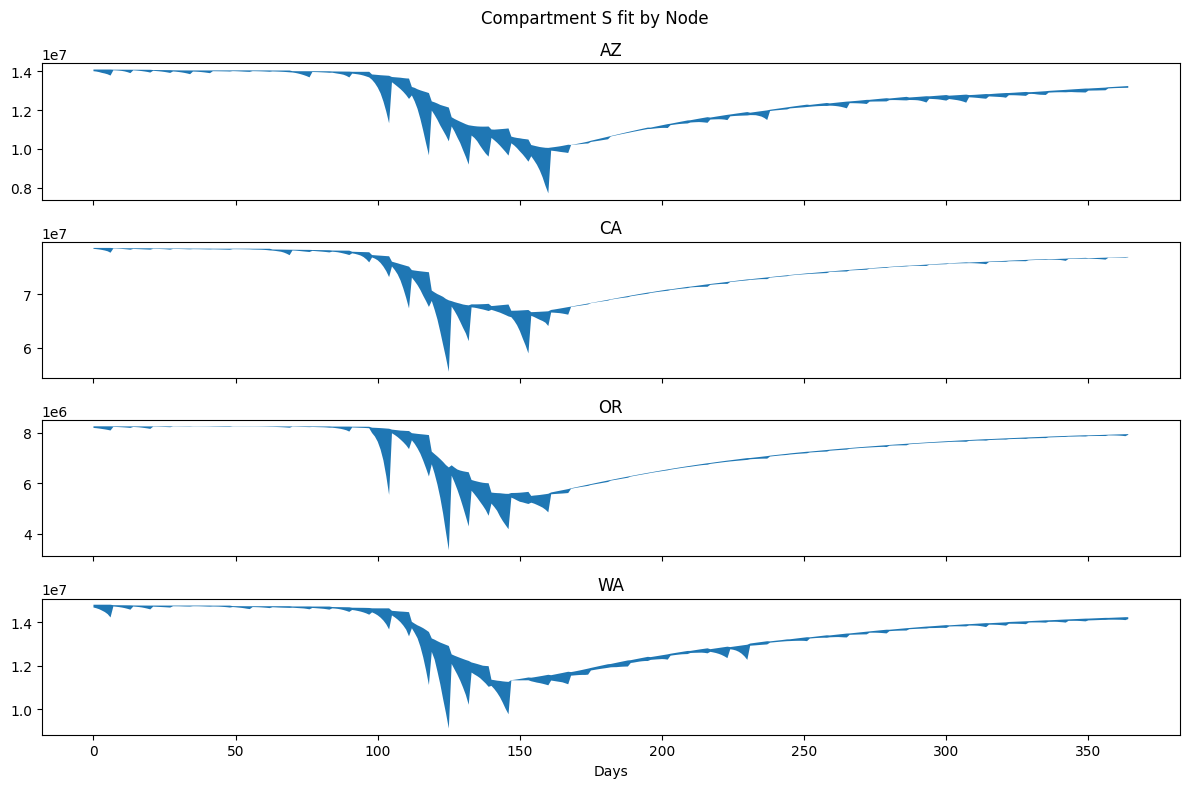

In [ ]:
t_range = np.arange(pf_rume.time_frame.duration_days)

fig,ax = plt.subplots(4,figsize = (12,8),sharex=True)

plt.suptitle('Compartment S fit by Node')
for node in range(pf_rume.scope.nodes):
        upper = np.percentile(pf_states[:,:,node,0],97.5,axis = 0)
        lower = np.percentile(pf_states[:,:,node,0],2.5,axis = 0)
        ax[node].set_title(f'{pf_rume.scope.labels[node]}')
        ax[node].fill_between(t_range,lower,upper)
ax[-1].set_xlabel('Days')
fig.tight_layout()

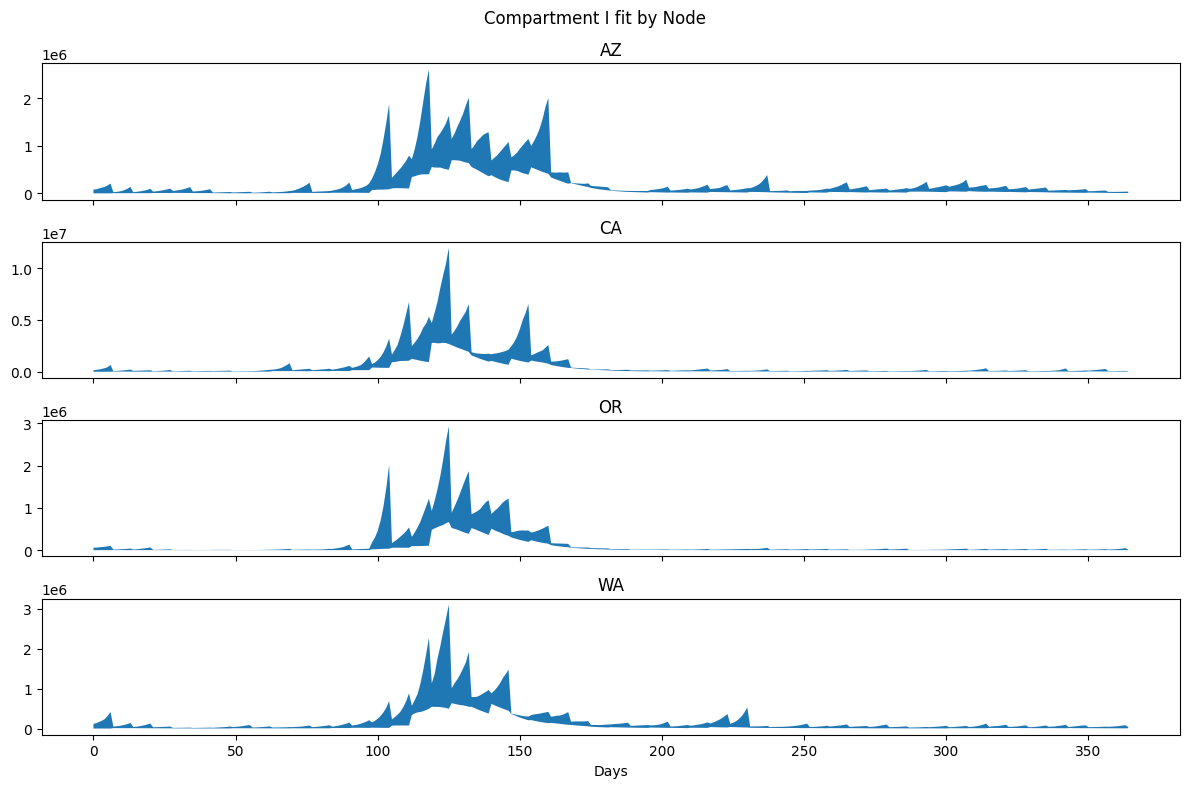

In [ ]:
fig,ax = plt.subplots(4,figsize = (12,8),sharex=True)

plt.suptitle('Compartment I fit by Node')
for node in range(pf_rume.scope.nodes):
        upper = np.percentile(pf_states[:,:,node,1],97.5,axis = 0)
        lower = np.percentile(pf_states[:,:,node,1],2.5,axis = 0)
        ax[node].set_title(f'{pf_rume.scope.labels[node]}')
        ax[node].fill_between(t_range,lower,upper)
ax[-1].set_xlabel('Days')
fig.tight_layout()

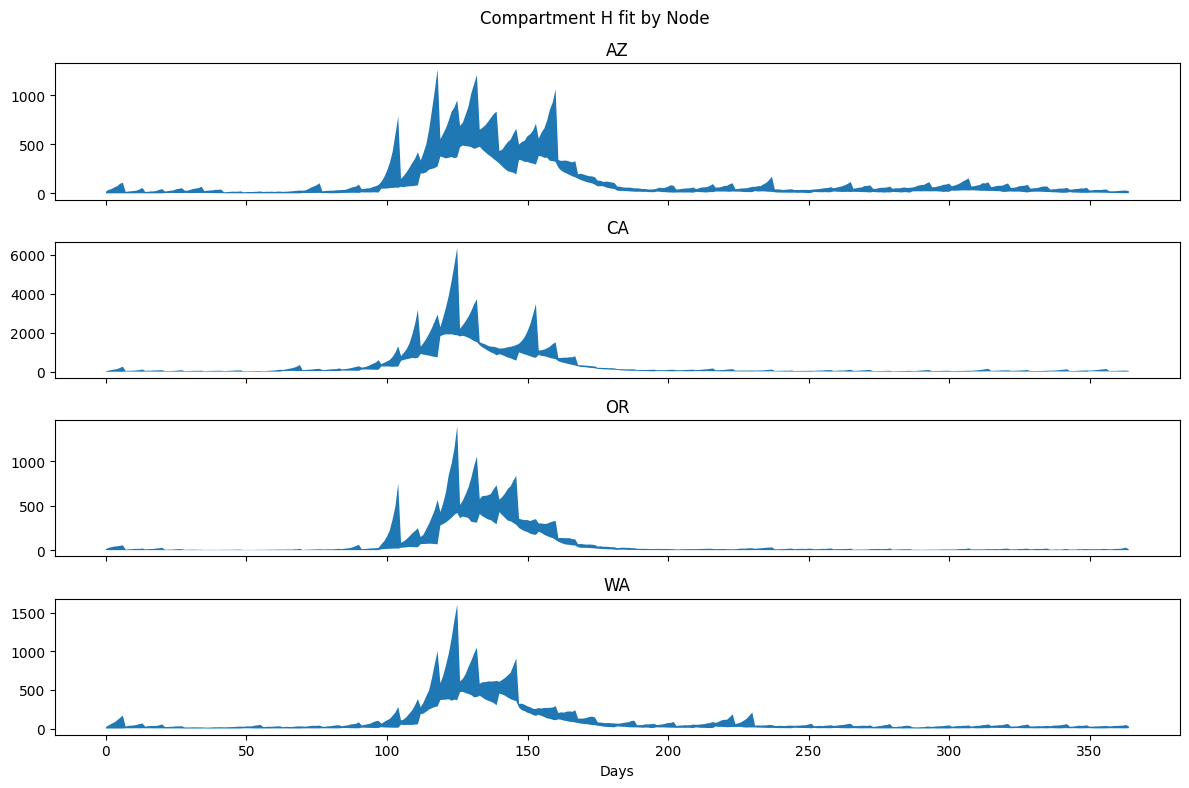

In [ ]:
fig,ax = plt.subplots(4,figsize = (12,8),sharex=True)

plt.suptitle('Compartment H fit by Node')
for node in range(pf_rume.scope.nodes):
        upper = np.percentile(pf_states[:,:,node,3],97.5,axis = 0)
        lower = np.percentile(pf_states[:,:,node,3],2.5,axis = 0)
        ax[node].set_title(f'{pf_rume.scope.labels[node]}')
        ax[node].fill_between(t_range,lower,upper)
ax[-1].set_xlabel('Days')
fig.tight_layout()